# Feature Selection and Model Training for Glucose Prediction

In this notebook, we will focus on feature selection and model training to predict clinically significant glucose swings in patients with type 1 diabetes. Our goal is to use the filtered data obtained from the exploratory data analysis (EDA) phase and develop a predictive model to assist in managing glucose levels more effectively.

The initial steps will involve loading the cleaned dataset, followed by a thorough examination of the features to determine which are most relevant for building our models. Based on our findings in the EDA notebook, we will incorporate temporal, demographic, and glucose variability features to construct a robust set of features.

After feature selection, we will proceed to model training, starting with a baseline linear regression model for benchmarking and then moving to more advanced time-sequenced models such as LSTM and GRU to capture the sequential nature of glucose readings ***[May go back to this if needed for now just started with main model]***. Our goal is to enhance the predictive accuracy of our system to support better glycemic control in individuals using CGM systems.



In [83]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [75]:
import pandas as pd

file_path = "/content/cleaned_glucose_tidepool_dataset_augmented.csv"
cleaned_data = pd.read_csv(file_path)

<ipython-input-75-0e64bd4889e5>:4: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  cleaned_data = pd.read_csv(file_path)


Lets take a look at our current data set


In [84]:
cleaned_data.head()

,time,type,value,file_name,date,hour,ageStart,biologicalSex,age_group,hour_of_day,time_of_day,day_of_week
0,2019-06-23 00:04:58+00:00,cbg,8.60366,train_39b32481640dc42af3ecdb07f8a3e5864d2e6d3e...,2019-06-23,0,64,Male,Seniors (56+),0,Night,6
1,2019-06-23 00:09:59+00:00,cbg,8.38163,train_39b32481640dc42af3ecdb07f8a3e5864d2e6d3e...,2019-06-23,0,64,Male,Seniors (56+),0,Night,6
2,2019-06-23 00:14:59+00:00,cbg,8.10409,train_39b32481640dc42af3ecdb07f8a3e5864d2e6d3e...,2019-06-23,0,64,Male,Seniors (56+),0,Night,6
3,2019-06-23 00:19:59+00:00,cbg,7.82655,train_39b32481640dc42af3ecdb07f8a3e5864d2e6d3e...,2019-06-23,0,64,Male,Seniors (56+),0,Night,6
4,2019-06-23 00:24:59+00:00,cbg,7.60452,train_39b32481640dc42af3ecdb07f8a3e5864d2e6d3e...,2019-06-23,0,64,Male,Seniors (56+),0,Night,6


## Step 1: Feature Engineering for Glucose Prediction

 Based on the EDA recommendations and the hybrid model's requirements, we will create additional features:
 - Temporal features: Time of day, day of the week
 - Glucose variability metrics: Rolling average, rate of glucose change
 - Demographic features: Age, biological sex, age group
 - Flags for hypo/hyperglycemia based on specific glucose thresholds

In [85]:
# Step 1.1: Creating Temporal Features with a flexible datetime format
# Extract time of day (morning, afternoon, evening, night) and day of the week
def extract_time_features(df):
    # Convert 'time' to datetime format with flexible parsing to handle inconsistent formats
    df['time'] = pd.to_datetime(df['time'], errors='coerce', format='mixed')

    # Create feature for hour of the day
    df['hour_of_day'] = df['time'].dt.hour

    # Create time of day (morning, afternoon, evening, night)
    bins = [0, 6, 12, 18, 24]
    labels = ['Night', 'Morning', 'Afternoon', 'Evening']
    df['time_of_day'] = pd.cut(df['hour_of_day'], bins=bins, labels=labels, right=False, include_lowest=True)

    # Create feature for day of the week
    df['day_of_week'] = df['time'].dt.dayofweek

    return df

# Re-apply time feature extraction
cleaned_data = extract_time_features(cleaned_data)


In [86]:
cleaned_data.head()


,time,type,value,file_name,date,hour,ageStart,biologicalSex,age_group,hour_of_day,time_of_day,day_of_week
0,2019-06-23 00:04:58+00:00,cbg,8.60366,train_39b32481640dc42af3ecdb07f8a3e5864d2e6d3e...,2019-06-23,0,64,Male,Seniors (56+),0,Night,6
1,2019-06-23 00:09:59+00:00,cbg,8.38163,train_39b32481640dc42af3ecdb07f8a3e5864d2e6d3e...,2019-06-23,0,64,Male,Seniors (56+),0,Night,6
2,2019-06-23 00:14:59+00:00,cbg,8.10409,train_39b32481640dc42af3ecdb07f8a3e5864d2e6d3e...,2019-06-23,0,64,Male,Seniors (56+),0,Night,6
3,2019-06-23 00:19:59+00:00,cbg,7.82655,train_39b32481640dc42af3ecdb07f8a3e5864d2e6d3e...,2019-06-23,0,64,Male,Seniors (56+),0,Night,6
4,2019-06-23 00:24:59+00:00,cbg,7.60452,train_39b32481640dc42af3ecdb07f8a3e5864d2e6d3e...,2019-06-23,0,64,Male,Seniors (56+),0,Night,6


In [87]:
# Step 1.2: Creating Glucose Variability Features
# Calculate the rolling average and rate of change for glucose levels
def create_glucose_variability_features(df):
    # Calculate rolling average over a 1-hour window (assuming data every 5 mins, approx 12 readings)
    df['glucose_rolling_mean'] = df['value'].rolling(window=12).mean()

    # Calculate rate of glucose change (difference between consecutive readings)
    df['glucose_rate_of_change'] = df['value'].diff()

    return df

# Apply glucose variability feature engineering
cleaned_data = create_glucose_variability_features(cleaned_data)

In [88]:
cleaned_data.head()

,time,type,value,file_name,date,hour,ageStart,biologicalSex,age_group,hour_of_day,time_of_day,day_of_week,glucose_rolling_mean,glucose_rate_of_change
0,2019-06-23 00:04:58+00:00,cbg,8.60366,train_39b32481640dc42af3ecdb07f8a3e5864d2e6d3e...,2019-06-23,0,64,Male,Seniors (56+),0,Night,6,NaN,NaN
1,2019-06-23 00:09:59+00:00,cbg,8.38163,train_39b32481640dc42af3ecdb07f8a3e5864d2e6d3e...,2019-06-23,0,64,Male,Seniors (56+),0,Night,6,NaN,-0.22203
2,2019-06-23 00:14:59+00:00,cbg,8.10409,train_39b32481640dc42af3ecdb07f8a3e5864d2e6d3e...,2019-06-23,0,64,Male,Seniors (56+),0,Night,6,NaN,-0.27754
3,2019-06-23 00:19:59+00:00,cbg,7.82655,train_39b32481640dc42af3ecdb07f8a3e5864d2e6d3e...,2019-06-23,0,64,Male,Seniors (56+),0,Night,6,NaN,-0.27754
4,2019-06-23 00:24:59+00:00,cbg,7.60452,train_39b32481640dc42af3ecdb07f8a3e5864d2e6d3e...,2019-06-23,0,64,Male,Seniors (56+),0,Night,6,NaN,-0.22203


In [89]:
import numpy as np
# Step 1.3: Flags for Hypo/Hyperglycemia
# Define thresholds for hypo and hyperglycemia (these values could be tuned later based on clinical, guidance @gary/@angel need input here )
HYPOGLYCEMIA_THRESHOLD = 3.9  # mmol/L
HYPERGLYCEMIA_THRESHOLD = 10.0  # mmol/L

def create_glucose_flags(df):
    # Create flag for hypoglycemia
    df['hypoglycemia_flag'] = np.where(df['value'] < HYPOGLYCEMIA_THRESHOLD, 1, 0)

    # Create flag for hyperglycemia
    df['hyperglycemia_flag'] = np.where(df['value'] > HYPERGLYCEMIA_THRESHOLD, 1, 0)

    return df

# Apply glucose flags feature engineering
cleaned_data = create_glucose_flags(cleaned_data)


In [90]:
cleaned_data.head()

,time,type,value,file_name,date,hour,ageStart,biologicalSex,age_group,hour_of_day,time_of_day,day_of_week,glucose_rolling_mean,glucose_rate_of_change,hypoglycemia_flag,hyperglycemia_flag
0,2019-06-23 00:04:58+00:00,cbg,8.60366,train_39b32481640dc42af3ecdb07f8a3e5864d2e6d3e...,2019-06-23,0,64,Male,Seniors (56+),0,Night,6,NaN,NaN,0,0
1,2019-06-23 00:09:59+00:00,cbg,8.38163,train_39b32481640dc42af3ecdb07f8a3e5864d2e6d3e...,2019-06-23,0,64,Male,Seniors (56+),0,Night,6,NaN,-0.22203,0,0
2,2019-06-23 00:14:59+00:00,cbg,8.10409,train_39b32481640dc42af3ecdb07f8a3e5864d2e6d3e...,2019-06-23,0,64,Male,Seniors (56+),0,Night,6,NaN,-0.27754,0,0
3,2019-06-23 00:19:59+00:00,cbg,7.82655,train_39b32481640dc42af3ecdb07f8a3e5864d2e6d3e...,2019-06-23,0,64,Male,Seniors (56+),0,Night,6,NaN,-0.27754,0,0
4,2019-06-23 00:24:59+00:00,cbg,7.60452,train_39b32481640dc42af3ecdb07f8a3e5864d2e6d3e...,2019-06-23,0,64,Male,Seniors (56+),0,Night,6,NaN,-0.22203,0,0



## Step 2: Baseline Model Training and Splitting the Dataset

In this step, we will split the cleaned dataset into training and testing sets, which is an essential part of building a predictive model. By doing so, we ensure that we have separate data to evaluate how well our model generalizes to unseen examples.

We will begin by splitting the data into **training** (80%) and **testing** (20%) sets. The training set will be used to fit the model, and the testing set will be used to evaluate its performance.

After splitting the dataset, we will train a **simple linear regression model** as our baseline model. The linear regression model will help us establish a benchmark for evaluating future, more complex models. By comparing the performance of this baseline with the hybrid LSTM + Informer model, we can measure improvements in prediction accuracy and evaluate whether the complexity added by deep learning architectures is justified.

Let's start by splitting the dataset and training our baseline linear regression model.
"""

In [107]:
# Step 2.1: Splitting the Dataset
# We'll split the data into features (X) and target (y)
# For simplicity, we'll use 'value' (glucose reading) as the target variable
X = cleaned_data.drop(columns=['value', 'time', 'file_name', 'date'])  # Drop unnecessary columns and target
y = cleaned_data['value']  # Glucose reading as target

# Perform one-hot encoding on categorical columns to convert them into numeric values
X_encoded = pd.get_dummies(X, columns=['type', 'time_of_day', 'biologicalSex', 'age_group'], drop_first=True)

# Fill NaN values with the mean of their respective columns after encoding
X_encoded.fillna(X_encoded.mean(), inplace=True)

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [108]:
# Step 2.2: Training a Baseline Linear Regression Model
# Initialize the linear regression model
linear_model = LinearRegression()

# Fit the model to the training data
linear_model.fit(X_train, y_train)

# Step 2.3: Evaluating the Baseline Model
# Make predictions on the testing set
y_pred = linear_model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Printing the performance metrics
print(f"Baseline Linear Regression Model Performance:\nMean Squared Error (MSE): {mse}\nR² Score: {r2}")

Baseline Linear Regression Model Performance:
Mean Squared Error (MSE): 0.7130767907500504
R² Score: 0.9224298628621928


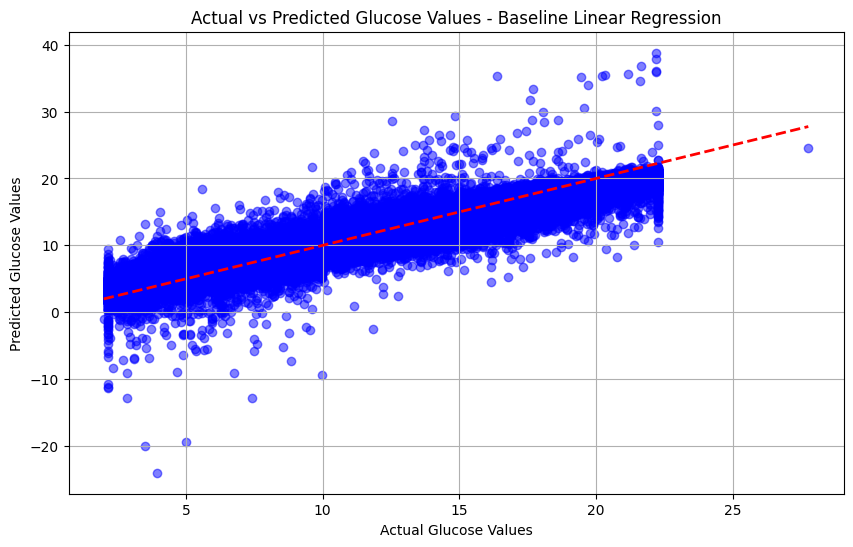

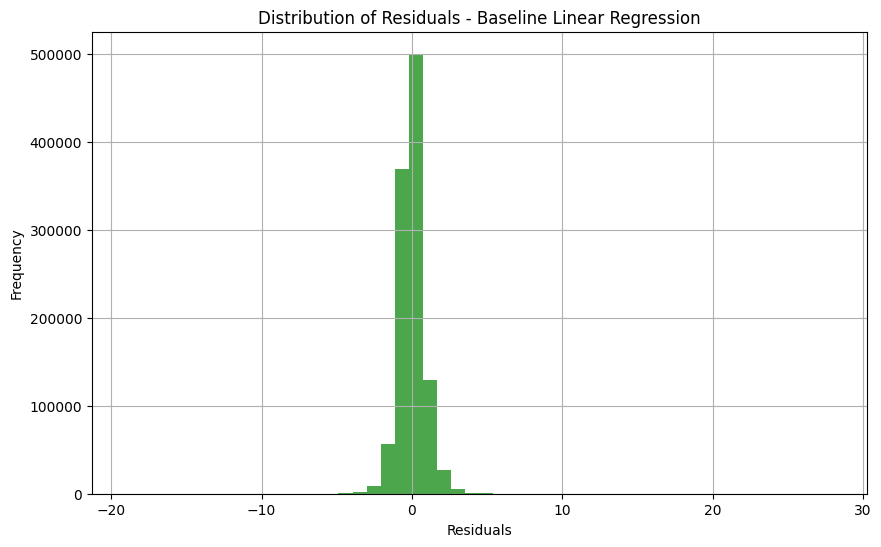

In [109]:
import matplotlib.pyplot as plt
# Plotting the predicted vs actual glucose values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='b')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Glucose Values')
plt.ylabel('Predicted Glucose Values')
plt.title('Actual vs Predicted Glucose Values - Baseline Linear Regression')
plt.grid(True)
plt.show()

# Plotting the residuals
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, color='g', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals - Baseline Linear Regression')
plt.grid(True)
plt.show()

### Loking at the base line


With an R² score of 0.922, the model explains approximately 92.2% of the variance in glucose values, which suggests that the model has reasonable explanatory power. However, given the scatter plot, this performance might be skewed by certain trends in the data and does not capture all nuances well.

**Scatter plot**

The model seems to underpredict for higher glucose values and overpredict for lower values, suggesting the linear model's limitations in capturing complex relationships.

The points are not tightly clustered around the line of perfect prediction, indicating that the model does not perform well across all glucose levels, particularly at the extremes.

**Risidual distribution**

The residuals are mostly centered around zero, which suggests that there is no major systematic bias (e.g., consistently overestimating or underestimating).
However, the spread of residuals is relatively wide, which means that the model has significant error in its predictions.
The residuals have some outliers on both ends, indicating that some glucose levels are poorly predicted.


The linear regression model provides a good initial benchmark, explaining much of the variance in glucose levels. However, the scatter plot and residuals indicate significant limitations in predicting extreme values and capturing complex non-linear trends.

The linear nature of the model is likely not sufficient to fully represent the underlying relationships in CGM data, which we understood would be the case since our data involves complex temporal patterns and non-linearities influenced by various physiological and lifestyle factors.

### Data Preparation for LSTM and Informer Models

Before training the LSTM and Informer models, we need to preprocess the dataset effectively. The data preparation involves:

1. Normalizing both the features and the target glucose values to ensure they are on comparable scales, which helps in stable model training.
2. Structuring the data into sliding window sequences, which is essential for time-series models like LSTMs and Informers that rely on temporal dependencies.
3. Splitting the data into training and testing sets and converting them to PyTorch tensors for model training.

These steps will set the foundation for our machine learning models to learn the complex temporal patterns present in glucose levels.

In [91]:
#Data Normalization

# Handle missing values before normalization
cleaned_data.fillna(method='bfill', inplace=True)  # Fill missing values using backward fill


# Normalize the features to a range between 0 and 1 using MinMaxScaler
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

features = cleaned_data.drop(columns=['value', 'time', 'file_name', 'date'])  # Drop unnecessary columns
features_encoded = pd.get_dummies(features, columns=['type', 'time_of_day', 'biologicalSex', 'age_group'], drop_first=True)
features_normalized = scaler_features.fit_transform(features_encoded)

# Normalize the target (glucose value) separately
target_normalized = scaler_target.fit_transform(cleaned_data[['value']])

# Combine normalized features with the normalized target glucose value
data_normalized = np.hstack((features_normalized, cleaned_data[['value']].values))

<ipython-input-91-eba2fc2c7444>:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  cleaned_data.fillna(method='bfill', inplace=True)  # Fill missing values using backward fill


In [92]:
data_normalized.shape

(5501340, 17)

In [94]:
data_normalized[0]

array([0.        , 0.84722222, 0.        , 1.        , 0.25614183,
       0.49850306, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 1.        ,
       0.        , 8.60366   ])

In [96]:
#Creating Sliding Window Sequences
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequence = data[i:i + seq_length]
        target = data[i + seq_length, -1]  # Target is the glucose value
        sequences.append(sequence)
        targets.append(target)
    return np.array(sequences), np.array(targets)

SEQ_LENGTH = 12  # Can be changed, this just for experimetation now (e.g., 1 hour of 5-minute intervals)
X, y = create_sequences(data_normalized, SEQ_LENGTH)

In [97]:
#Convert Data to PyTorch Tensors

# Convert the sliding window sequences to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)
class GlucoseDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [98]:
# Split data into training and testing sets
train_size = int(0.8 * len(X_tensor))
test_size = len(X_tensor) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(GlucoseDataset(X_tensor, y_tensor), [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


## Step 3: Defining the LSTM model

With the results of the baseline linear regression model above, we saw that while it performed reasonably well (with an R² score of 0.922), it struggled with capturing complex non-linear relationships and temporal patterns in glucose level data.

To address these limitations, we are now going to implement an LSTM (Long Short-Term Memory) model to better capture the sequential dependencies in the glucose data. The LSTM model is well-suited for time-series forecasting and can effectively model short- to medium-term time horizons.

We will proceed to define, train, and evaluate this LSTM model, followed by a comparison against the baseline linear regression model.





The LSTM  architecture is well-suited for time-series prediction tasks due to its ability to maintain information over longer sequences. Given that our data involves glucose level readings taken over time, we chose an LSTM model to capture temporal dependencies effectively.


In [99]:
### Step 3.1: Defining the LSTM Model

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, lstm_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, lstm_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out



Next we will initialize the LSTM model, set up the loss function, and configure the optimizer to train the model.

- **Model Initialization**: We create an instance of the LSTM model using the architecture defined in Step 3.1. The model has 2 LSTM layers with a hidden dimension of 128.
- **Loss Function**: We use Mean Squared Error (MSE) as the loss function, which is commonly used for regression tasks to minimize the difference between predicted and actual values.
- **Optimizer**: We use the Adam optimizer with a learning rate of 0.0001 to improve the training process by adapting the learning rate for each parameter.

This setup is crucial for ensuring that our model is capable of learning from the data and minimizing the prediction error effectively.

In [100]:
# Step 3.2: Initializing the LSTM Model, Loss Function, and Optimizer
input_dim = X.shape[2]
hidden_dim = 128
lstm_layers = 2
output_dim = 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LSTMModel(input_dim, hidden_dim, lstm_layers, output_dim).to(device)
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

 Finally we will train the LSTM model using the training dataset. The model will be trained for 10 epochs, with each epoch representing a complete pass over the training dataset.

- **Loss Function**: We are using Mean Squared Error (MSE) as the loss function, which is appropriate for regression tasks as it penalizes larger errors more heavily.
- **Optimizer**: The Adam optimizer is used with a learning rate of 0.0001 to help the model converge more efficiently.

During training, we compute the loss for each batch, backpropagate the gradients, and update the model parameters. The average loss for each epoch is printed to monitor the model's progress.



In [101]:
from tqdm import tqdm

def train_lstm_model(model, train_loader, loss_function, optimizer, epochs=10, patience=3):
    model.train()
    min_loss = float('inf')
    no_improve_epochs = 0
    progress_bar = tqdm(range(epochs), desc='Training Progress', leave=True)

    for epoch in progress_bar:
        total_loss = 0
        for X_batch, y_batch in train_loader:
            # Move data to the same device as the model
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = loss_function(y_pred.squeeze(), y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader) if len(train_loader) > 0 else float('inf')
        print(f"Epoch {epoch+1}, Loss: {avg_loss}")

        # Update progress bar
        progress_bar.set_postfix({'Epoch Loss': avg_loss})

        # Early stopping logic
        if avg_loss < min_loss:
            min_loss = avg_loss
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= patience:
                print(f"Stopping early after {epoch+1} epochs with no improvement.")
                break

# Train the LSTM model
train_lstm_model(model, train_loader, loss_function, optimizer, epochs=10)



Training Progress:  10%|█         | 1/10 [03:31<31:46, 211.89s/it, Epoch Loss=0.223]

Epoch 1, Loss: 0.2225901396631974


Training Progress:  20%|██        | 2/10 [07:04<28:19, 212.45s/it, Epoch Loss=0.0676]

Epoch 2, Loss: 0.06763791734290978


Training Progress:  30%|███       | 3/10 [10:36<24:45, 212.26s/it, Epoch Loss=0.0661]

Epoch 3, Loss: 0.0661285507276044


Training Progress:  40%|████      | 4/10 [14:09<21:13, 212.28s/it, Epoch Loss=0.0654]

Epoch 4, Loss: 0.06537192063919937


Training Progress:  50%|█████     | 5/10 [17:41<17:41, 212.28s/it, Epoch Loss=0.0649]

Epoch 5, Loss: 0.06493021992797568


Training Progress:  60%|██████    | 6/10 [21:13<14:09, 212.38s/it, Epoch Loss=0.0646]

Epoch 6, Loss: 0.06461399988313239


Training Progress:  70%|███████   | 7/10 [24:45<10:36, 212.20s/it, Epoch Loss=0.0643]

Epoch 7, Loss: 0.06434643803490644


Training Progress:  80%|████████  | 8/10 [28:18<07:04, 212.46s/it, Epoch Loss=0.0641]

Epoch 8, Loss: 0.06414410975061571


Training Progress:  90%|█████████ | 9/10 [31:51<03:32, 212.56s/it, Epoch Loss=0.064]

Epoch 9, Loss: 0.06396722444528496


Training Progress: 100%|██████████| 10/10 [35:24<00:00, 212.44s/it, Epoch Loss=0.0638]

Epoch 10, Loss: 0.06378593534246056


After training the LSTM model, we will evaluate its performance on the test set. We use Mean Squared Error and R² score as evaluation metrics to understand how well the model predicts glucose levels.

- The MSE will helps us understand the average squared difference between predicted and actual values.
- The R² score will measur how well the model explains the variance in the target variable. A hiher R² score will indicate a better performance.

We will also visualize the actual vs. predicted glucose values to get an intuitive sense of the model's accuracy.

LSTM Model Performance Mean Squared Error (MSE): 0.06417703645821743 R² Score: 0.9930229831171057


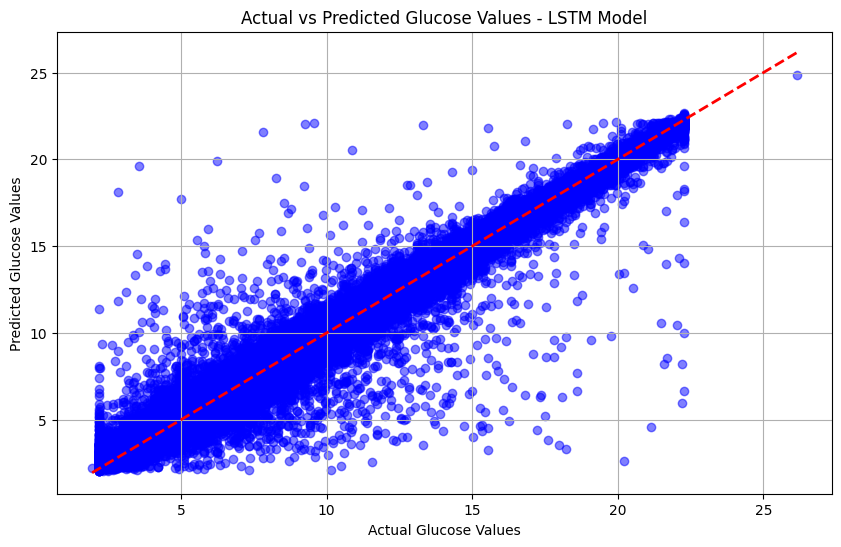

In [105]:
def evaluate_lstm_model(model, test_loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            # Move data to the same device as the model
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            predictions.extend(y_pred.squeeze().tolist())
            actuals.extend(y_batch.tolist())
    mse = mean_squared_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)
    print(f"LSTM Model Performance Mean Squared Error (MSE): {mse} R² Score: {r2}")
    return actuals, predictions

actuals, predictions = evaluate_lstm_model(model, test_loader)

# Plotting Actual vs Predicted Glucose Values for LSTM Model
plt.figure(figsize=(10, 6))
plt.scatter(actuals, predictions, alpha=0.5, color='b')
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r--', lw=2)
plt.xlabel('Actual Glucose Values')
plt.ylabel('Predicted Glucose Values')
plt.title('Actual vs Predicted Glucose Values - LSTM Model')
plt.grid(True)
plt.show()

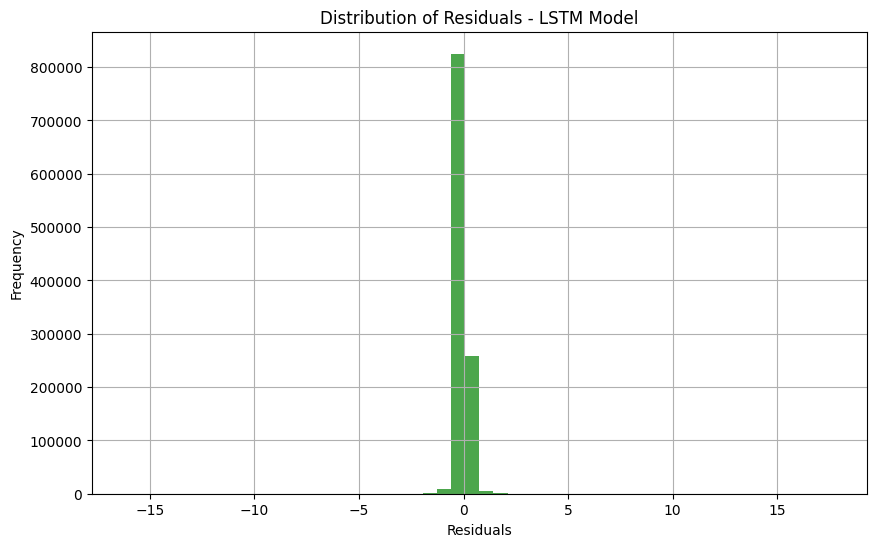

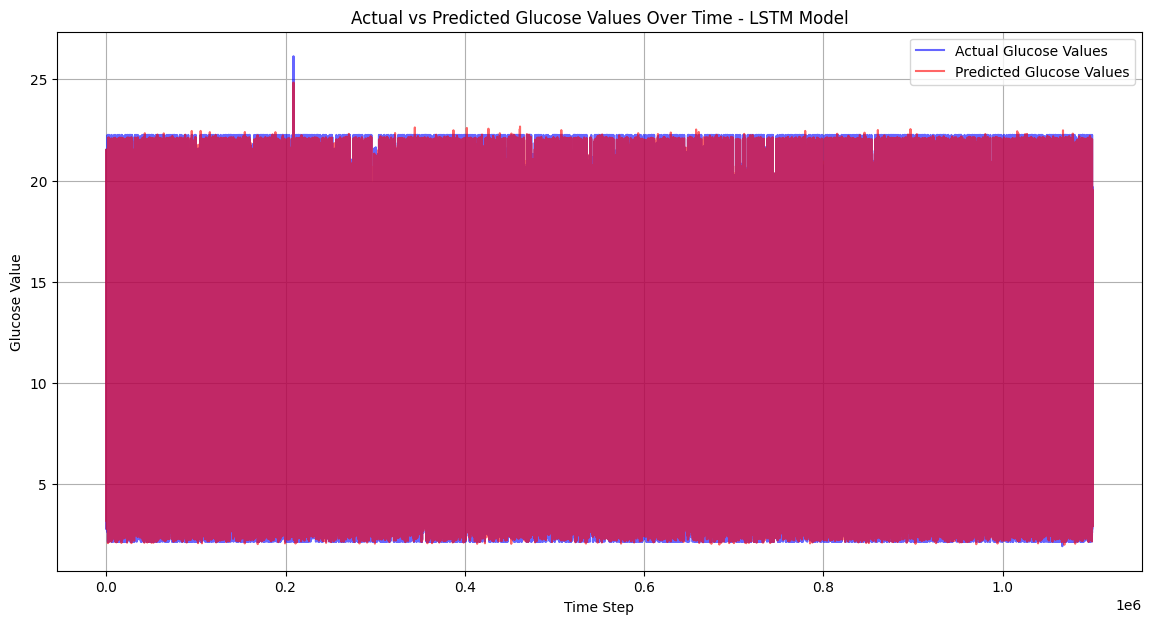

In [106]:
# Plotting Residuals for LSTM Model
residuals = [actual - pred for actual, pred in zip(actuals, predictions)]
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, color='g', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals - LSTM Model')
plt.grid(True)
plt.show()

# Plotting Actual vs Predicted Glucose Values Over Time
plt.figure(figsize=(14, 7))
plt.plot(actuals, label='Actual Glucose Values', color='blue', alpha=0.6)
plt.plot(predictions, label='Predicted Glucose Values', color='red', alpha=0.6)
plt.xlabel('Time Step')
plt.ylabel('Glucose Value')
plt.title('Actual vs Predicted Glucose Values Over Time - LSTM Model')
plt.legend()
plt.grid(True)
plt.show()

In [110]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Calculating MAE and MAPE for the LSTM model
mae = mean_absolute_error(actuals, predictions)
mape = mean_absolute_percentage_error(actuals, predictions)

print(f"LSTM Model Performance:\nMean Absolute Error (MAE): {mae}\nMean Absolute Percentage Error (MAPE): {mape}")


LSTM Model Performance:
Mean Absolute Error (MAE): 0.12540370572949064
Mean Absolute Percentage Error (MAPE): 0.01786803175102757


### Evaluation of the LSTM model

Results:

Mean Squared Error (MSE): 0.0642

R² Score: 0.9930

Mean Absolute Error (MAE): 0.1254

Mean Absolute Percentage Error (MAPE): 0.0179

Our MSE of 0.0642 suggests that the model has a relatively low average squared error, which indicates that most predictions are close to the actual values. The R² score of 0.9930 signifies that the model explains 99.3% of the variance in glucose levels, highlighting strong predictive power.

 The MAE of 0.1254 this represents the average absolute difference between predicted and actual values, which as we can see is quite low, indicating high accuracy.

The MAPE of 0.0179 shows that, on average, the model's predictions are within 1.79% of the actual values, further demonstrating the model's reliability.

Looking at our charts;

- **Actual vs Predicted Glucose Values Scatter Plot:** This plot shows the relationship between actual and predicted glucose values. The red dashed line represents the ideal case where predicted values match the actual values. We see most of the points lie close to this line, shwing us some good predictive performance.



- **Distribution of Residuals**: A histogram of residuals [*the difference between actual and predicted values*] shows that most residuals are centered around zero this indicating that the model is not biased and performs well across different glucose levels.



- **Actual vs Predicted Glucose Values Over Time:** A time-series plot compares the predicted glucose values with the actual glucose values over the ***entire test set***. We see the predicted values closely follow the actual values, shwing the LSTM's effectiveness in modeling the temporal pattern